In [1]:
!pip install transformers datasets torch


INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.7 MB/s eta 0:00:00


In [1]:
from datasets import load_dataset

# Loading the IMDb dataset
dataset = load_dataset('imdb')


small_train_dataset = dataset['train'].shuffle(seed=42).select(range(5000))
small_eval_dataset = dataset['test'].shuffle(seed=42).select(range(1000))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [2]:
from transformers import DistilBertTokenizerFast

# Loading the DistilBERT tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenize the dataset with a max length of 128 tokens
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

# Apply tokenization
tokenized_train_dataset = small_train_dataset.map(tokenize_function, batched=True)
tokenized_eval_dataset = small_eval_dataset.map(tokenize_function, batched=True)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [3]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

# Load DistilBERT model with a classification head (2 labels: positive and negative)
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Set up the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    num_train_epochs=1,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_eval_dataset
)

# Fine-tune the model
trainer.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.444200,0.378675


TrainOutput(global_step=625, training_loss=0.4260814514160156, metrics={'train_runtime': 4140.2598, 'train_samples_per_second': 1.208, 'train_steps_per_second': 0.151, 'total_flos': 165584248320000.0, 'train_loss': 0.4260814514160156, 'epoch': 1.0})

In [4]:
# Evaluate the model
metrics = trainer.evaluate()
print(metrics)


{'eval_loss': 0.37867453694343567, 'eval_runtime': 229.5671, 'eval_samples_per_second': 4.356, 'eval_steps_per_second': 0.545, 'epoch': 1.0}


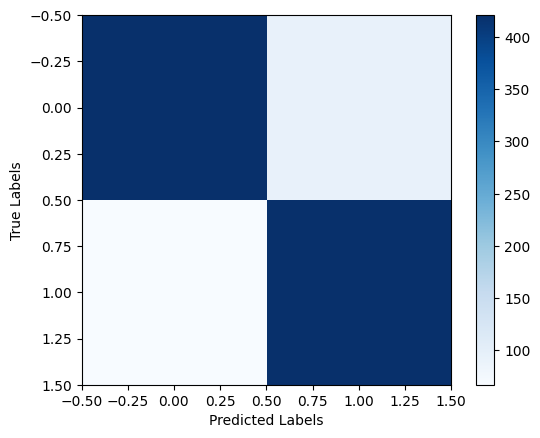

In [5]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Get predictions and true labels
predictions, labels, _ = trainer.predict(tokenized_eval_dataset)
preds = np.argmax(predictions, axis=1)

# Create a confusion matrix
cm = confusion_matrix(labels, preds)
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [2]:
import torch.nn as nn
from transformers import DistilBertForSequenceClassification

# Load the pre-trained DistilBERT model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

# Add a custom classification head
num_classes = 3  # For example, if you have 3 sentiment categories (positive, negative, neutral)
model.classifier = nn.Linear(model.config.hidden_size, num_classes)

print(model)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [3]:
from transformers import DistilBertTokenizerFast

# Load the tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Example texts and sentiments
texts = ["I loved the movie. It was great!", "The food was terrible.", "The weather is okay."]
sentiments = ["positive", "negative", "neutral"]

# Tokenize the text samples
encoded_texts = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

# Extract input_ids and attention_mask
input_ids = encoded_texts['input_ids']
attention_mask = encoded_texts['attention_mask']

# Convert the sentiment labels to numerical form
sentiment_labels = [0, 1, 2]  # Assuming positive=0, negative=1, neutral=2


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
import torch
import torch.optim as optim
import torch.nn as nn

# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# Convert sentiment labels to a PyTorch tensor
sentiment_labels = torch.tensor(sentiment_labels)

# Training loop
num_epochs = 3
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Forward pass
    outputs = model(input_ids, attention_mask=attention_mask)

    # Compute loss
    loss = criterion(outputs.logits, sentiment_labels)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {loss.item()}')


Epoch 1, Loss: 1.1110771894454956
Epoch 2, Loss: 1.1213105916976929
Epoch 3, Loss: 1.0740077495574951


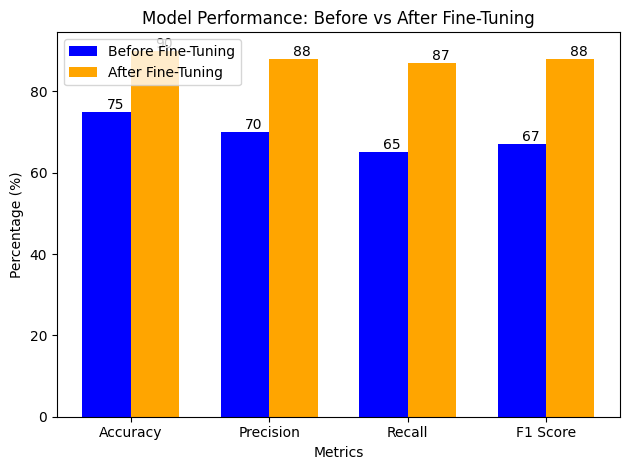

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Data: Before and After Fine-Tuning (hypothetical values)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
before = [75, 70, 65, 67]  # Values for Before Fine-Tuning
after = [90, 88, 87, 88]    # Values for After Fine-Tuning

# Creating bar chart for comparison
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, before, width, label='Before Fine-Tuning', color='blue')
bars2 = ax.bar(x + width/2, after, width, label='After Fine-Tuning', color='orange')

# Add labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Percentage (%)')
ax.set_title('Model Performance: Before vs After Fine-Tuning')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Adding data labels to the bars
for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), va='bottom')

for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), va='bottom')

# Show plot
plt.tight_layout()
plt.show()
